### lgb to model wobacon

In [1]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_pinball_loss, make_scorer

In [2]:
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/Coding Projects/woba modeling/data/')
df = pd.read_csv('pitch/pitch_cleaned.csv').drop(columns=['Unnamed: 0'])
df['year'] = pd.to_datetime(df['year']).dt.year

##### Cleaning for Task

In [3]:
df = df[df['description'] == 'hit_into_play']
df = df[['batter','year', 'woba_value', 'launch_speed', 'launch_angle', 'spray_angle']]
df = df[df['launch_speed'].notna()] # mcar 

In [4]:
df = df.dropna()

In [5]:
# df_train = df[df['year'] < 2025]
df_train = df

In [6]:
X = (df_train[['launch_speed', 'launch_angle']])
y = df_train['woba_value']

##### Train Val

no need for a test set as I am purposely holding out 2025 data. I want to test on all 2025 data to compare the predection power of this model to xwobacon

In [7]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=26) 

##### Hyper Parameters Tuning

In [8]:
model = lgb.LGBMRegressor(random_state=26, n_jobs=5, metric='quantile', objective='quantile')

##### Random Search

In [9]:
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [ ]:
rnd_search_params = {
    'boosting_type': ['gbdt'],
    'learning_rate': [0.1, 0.01],          
    'num_leaves': np.linspace(2, 200, 25, dtype=int),
    'max_depth': np.linspace(2, 19, 7, dtype=int),  
    'min_data_in_leaf': np.linspace(1, 40, 10, dtype=int),         
    'subsample': np.linspace(0.3, 0.8, 7),               
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'n_estimators': np.linspace(100, 1500, 15, dtype=int),
    'lambda_l2': [1, 3, 5, 10, 20, 25, 50],
    'lambda_l1': [0.001, 0.01, 1, 3, 5]
}

fit_params = {
    "callbacks": [lgb.early_stopping(stopping_rounds=75, verbose=False)], 
    "eval_set": [(x_val, y_val)],
    "eval_metric": 'quantile' 
}

# for early stopping
x_combined = np.concatenate((x_train, x_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)
split_index = [-1] * len(x_train) + [0] * len(x_val)
pds = PredefinedSplit(test_fold=split_index)

all_best_params = {}
all_best_scores = {}

for q in quantiles:
    print(f"Running Randomized Search for quantile: {q}")

    pinball_scorer = make_scorer(mean_pinball_loss, greater_is_better=False, alpha=q)

    model = lgb.LGBMRegressor(
                            alpha=q,
                            max_bin=63,
                            random_state=26,
                            n_jobs=5,
                            metric='quantile', 
                            objective='quantile')

    
    rnd_searcher = RandomizedSearchCV(model, param_distributions=rnd_search_params, cv=pds, scoring=pinball_scorer,
                                    n_iter=60, random_state=26, verbose=1, n_jobs=3) 
    
    print(model.get_params)
    search = rnd_searcher.fit(x_combined, y_combined, **fit_params)
    
    print(f"Best parameters for quantile {q}: {search.best_params_}")
    print(f"Best score for quantile {q}: {-search.best_score_}")
    
    all_best_params[q] = search.best_params_
    all_best_scores[q] = search.best_score_

Running Randomized Search for quantile: 0.05
<bound method LGBMModel.get_params of LGBMRegressor(alpha=0.05, max_bin=63, metric='quantile', n_jobs=5,
              objective='quantile', random_state=26)>
Fitting 1 folds for each of 60 candidates, totalling 60 fits
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00124

#### Paramaters

In [11]:
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_numpy_types(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_numpy_types(i) for i in obj]
    return obj

serializable_params = convert_numpy_types(all_best_params)

with open('ev_dir_params.json', 'w') as f:
    json.dump(serializable_params, f, indent=4)

print("Saved best param")

Saved best param


In [14]:
with open(r'C:/Users/dalto/OneDrive/Pictures/Documents/Projects/Coding Projects/woba modeling/data/parameters/ev_dir_params.json', 'r') as f:
    ev_dir_params = json.load(f)

#### Model Fit

In [15]:
models = {}
quantiles = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
for q in quantiles:
    quantile_model = lgb.LGBMRegressor(**ev_dir_params[str(q)], alpha=q, random_state=26, n_jobs=-1)
    quantile_model.fit(x_train, y_train, 
                       eval_set=[(x_val, y_val)], 
                       callbacks=[lgb.early_stopping(stopping_rounds=40, verbose=False)])
    models[q] = quantile_model

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 407
[LightGBM] [Info] Number of data points in the train set: 787823, number of used features: 2
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 w

##### Testing

In [16]:
y_pred = models[.55].predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
results_df = pd.DataFrame({'actual': y, 'predicted': y_pred})
results_df = results_df.join(df[['batter', 'year']])
print(f'RMSE: {rmse}')

[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
RMSE: 0.4309147881813464


In [17]:
stats = ['predicted']
corr_next = results_df.groupby(['batter', 'year'])['predicted'].mean().reset_index()
count = results_df.groupby(['batter', 'year']).size().reset_index(name='count')
corr_next = corr_next.merge(count, on=['batter', 'year'])
corr_next = corr_next[corr_next['count'] > 60]

for stat in stats:
    corr_next[f'{stat}_next'] = corr_next.groupby('batter')[stat].shift(-1)

corr_next = corr_next.dropna(subset=[f'{stat}_next' for stat in stats])

corrs = {}
for stat in stats:
    corrs[stat] = corr_next[[stat, f'{stat}_next']].corr().iloc[0, 1]
    corrs[stat] = corrs[stat] ** 2

print(corrs)

{'predicted': 0.4342526993517071}


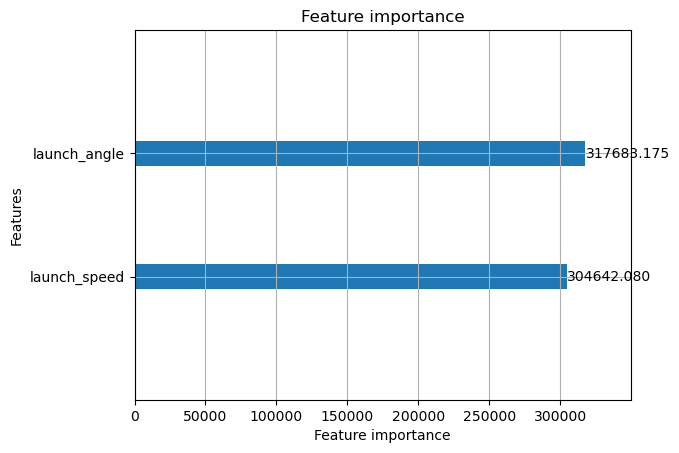

In [18]:
lgb.plot_importance(models[.55], importance_type='gain')
plt.show()

In [22]:
grouped_results = results_df.groupby(['year', 'batter'])[['actual', 'predicted']].agg(['mean', 'count'])
grouped_results.columns = ['_'.join(col).strip() for col in grouped_results.columns.values]
grouped_results = grouped_results.reset_index()
grouped_rmse = np.sqrt(mean_squared_error(grouped_results['actual_mean'], grouped_results['predicted_mean']))
qualified_results = grouped_results[grouped_results['actual_count'] > 60]
qualified_rmse = np.sqrt(mean_squared_error(qualified_results['actual_mean'], qualified_results['predicted_mean']))
print(f'RMSE for batters with more than 60 plate appearances: {qualified_rmse}')
print(f'Grouped RMSE {grouped_rmse}')

RMSE for batters with more than 60 plate appearances: 0.04463263716929888
Grouped RMSE 0.11175876568018256


##### Find Quintiles for Each Data Point

In [8]:
quantile_predictions = pd.DataFrame()

for q in models:
    quantile_predictions[f'q_{q}'] = models[q].predict(x_25)

quantile_predictions.set_index(x_25.index, inplace=True)

NameError: name 'models' is not defined

In [25]:
quantile_predictions['name'] = df_25['batter']
quantile_predictions['year'] = df_25['year']
quantile_cols = sorted([col for col in quantile_predictions.columns if col.startswith('q_')])
quantile_predictions[quantile_cols] = np.sort(quantile_predictions[quantile_cols].values, axis=1)
quantile_predictions[quantile_cols] = quantile_predictions[quantile_cols].clip(lower=0)

In [26]:
player_quant = quantile_predictions.groupby('name').mean()
player_quant['pitch_count'] = quantile_predictions.groupby('name').size()
player_quant['pred_std'] = player_quant[quantile_cols].std(axis=1)
player_quant = player_quant[player_quant['pitch_count'] > 60]


# Find and print the top 5 players with the highest standard deviation
print("Top 5 players with highest prediction standard deviation:")
top_5_highest_std = player_quant.nlargest(5, 'pred_std')
print(top_5_highest_std['pred_std'])

# Find and print the top 5 players with the lowest standard deviation
print("Top 5 players with lowest prediction standard deviation:")
top_5_lowest_std = player_quant.nsmallest(5, 'pred_std')
print(top_5_lowest_std['pred_std'])


Top 5 players with highest prediction standard deviation:
name
aaron judge      0.012219
adael amador     0.012219
kyren paris      0.011666
shohei ohtani    0.011569
luis torrens     0.011422
Name: pred_std, dtype: float64
Top 5 players with lowest prediction standard deviation:
name
jonah bride       0.006798
tim anderson      0.006936
brooks baldwin    0.007335
gary sanchez      0.007544
trey sweeney      0.007628
Name: pred_std, dtype: float64


##### Quant Predections For Everything

In [25]:
models = {}
for q in quantiles:
    quantile_model = lgb.LGBMRegressor(**ev_dir_params[str(q)], alpha=q, random_state=26, n_jobs=-1)
    quantile_model.fit(X, y, 
                       eval_set=[(x_val, y_val)], 
                       callbacks=[lgb.early_stopping(stopping_rounds=40, verbose=False)])
    models[q] = quantile_model

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 866880, number of used features: 3
[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples

In [26]:
full_predictions = pd.DataFrame()

for q in models:
    full_predictions[f'q_{q}'] = models[q].predict(X)

full_predictions.set_index(X.index, inplace=True)

[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
[LightGBM] [Warning] min_data_in_le

In [27]:
full_predictions['name'] = df['batter']
full_predictions['year'] = df['year']
quantile_cols = sorted([col for col in full_predictions.columns if col.startswith('q_')])
full_predictions[quantile_cols] = np.sort(full_predictions[quantile_cols].values, axis=1)
full_predictions[quantile_cols] = full_predictions[quantile_cols].clip(lower=0)
full_predictions[quantile_cols] = full_predictions[quantile_cols].clip(upper=2.01775) # average hr woba over last 8 years
full_predictions = full_predictions.reset_index()
cols = ['name', 'year'] + [col for col in full_predictions.columns if col not in ['name', 'year', 'index']]
full_predictions = full_predictions[cols]
full_predictions.to_csv('quantile_predections/ev_dir_pitch.csv')